In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import time
import datetime
import numpy as np
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from fuzzywuzzy import process

c:\Users\YOGA PRATAMA\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Membaca dataset
df = pd.read_excel('translate dataset/eu_english_dataset.xlsx')

# Menampilkan beberapa baris pertama dari dataframe
df.head()

,english_translation
0,Bonn ❤️ https://t.co/TOLPGlWvQt
1,"Zurich, Switzerland \nvia: joanna_got https://..."
2,"Zurich, Switzerland \nvia: joanna_got https://..."
3,"Zurich, Switzerland \nvia: joanna_got https://..."
4,"Zurich, Switzerland \nvia: joanna_got https://..."


In [3]:
# Fungsi untuk mendapatkan sentimen
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Terapkan analisis sentimen
df['polarity'] = df['english_translation'].apply(get_sentiment)

# Fungsi untuk memberi label sentimen
def label_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Terapkan pelabelan
df['sentiment_label'] = df['polarity'].apply(label_sentiment)

# Tampilkan dataframe yang telah diperbarui dengan label sentimen
df.head()

,english_translation,polarity,sentiment_label
0,Bonn ❤️ https://t.co/TOLPGlWvQt,0.0,neutral
1,"Zurich, Switzerland \nvia: joanna_got https://...",0.0,neutral
2,"Zurich, Switzerland \nvia: joanna_got https://...",0.0,neutral
3,"Zurich, Switzerland \nvia: joanna_got https://...",0.0,neutral
4,"Zurich, Switzerland \nvia: joanna_got https://...",0.0,neutral


In [4]:
# Menghapus baris kosong
df = df.dropna()

# Menghapus baris duplikat, menyimpan kejadian pertama
df = df.drop_duplicates()

# Verifikasi hasil
print(f"Jumlah baris setelah menghapus baris kosong dan duplikat: {len(df)}")
df.head()

Jumlah baris setelah menghapus baris kosong dan duplikat: 509


,english_translation,polarity,sentiment_label
0,Bonn ❤️ https://t.co/TOLPGlWvQt,0.00,neutral
1,"Zurich, Switzerland \nvia: joanna_got https://...",0.00,neutral
18,"Heidelberg, Germany\n#Heidelberg https://t.co/...",0.00,neutral
21,"Lots of rain in the coming days, especially in...",-0.05,negative
28,It's raining like from a cable.....weather onl...,0.00,neutral


In [5]:
# Mengecek apakah ada baris yang semua kolomnya kosong
kosong = df.isnull().all(axis=1)

# Menampilkan jumlah baris yang kosong seluruhnya
print(f"Jumlah baris yang kosong seluruhnya: {kosong.sum()}")

# Menampilkan baris-baris yang kosong seluruhnya
print(df[kosong])

Jumlah baris yang kosong seluruhnya: 0
Empty DataFrame
Columns: [english_translation, polarity, sentiment_label]
Index: []


In [6]:
df['sentiment_label'].value_counts()

sentiment_label
neutral     315
positive    134
negative     60
Name: count, dtype: int64

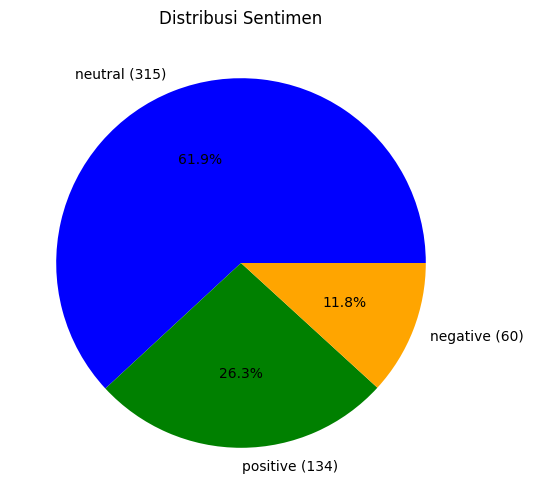

In [7]:
# Definisikan warna untuk setiap label sentimen
colors = {
    'positive': 'green',
    'negative': 'orange',
    'neutral': 'blue'
}

# Hitung jumlah nilai untuk masing-masing kelas
sentiment_counts = df['sentiment_label'].value_counts()

# Set label dengan jumlah
labels = [f"{label} ({count})" for label, count in sentiment_counts.items()]

# Buat pie chart
plt.figure(figsize=(10, 6))
sentiment_counts.plot.pie(
    autopct='%1.1f%%',
    colors=[colors[label.split(' ')[0]] for label in labels],
    labels=labels
)

plt.title('Distribusi Sentimen')
plt.ylabel('')
plt.show()


In [8]:
# Daftar nama kota
city_list = [
    "bonn", "maas", "Liège", "zurich", "switzerland", "heidelberg", "germany", "Achterhoek", "koblenz", 
    "strasbourg", "Bas-Rhin", "Haguenau", "south limburg", "Heerlen", "lucerne", "mylucerne", "gelderland", 
    "Ribécourt-Dreslincourt", "limburg", "caumerbeek", "Leiden", "Netherlands", "belgium", "liege", 
    "wuppertal", "Wupper", "Wuppertal-Oberbarmen", "namur", "pm", "aarau", "canton", "aargau",  
    "french", "stolberg", "lohovo", "bosnia", "rize", "guneysu", "france", "near", "aachen", "starkregen", 
    "Rotterdam", "Mönchengladbach", "Cherbourg-Octeville Manche", "ardennes", "theux", "venlo", "maastricht",
    "kyllburg", "trier", "bitburg", "North Rhine-Westphalia", "lake", "juli", "Vresse-sur-Semois", "valkenburg",
    "Chenee", "deutschland", "Valkenburg aan de Geul", "Solingen-Haasenmühle", "krefeld", "SouthAfrica", 
    "South Africa", "maasdorpen", "sillery", "heugem", "belgique", "essen", "july", "bern", "Gronauer Mühlenweg", 
    "Bergisch Gladbach", "Chaudfontaine", "Noord-Brabant", "Waalkade", "Nijmegen", "Rijnkade", "Arnhem", 
    "utrecht", "Venlo", "Kessel", "Baarlo", "PSV Eindhoven", "galatasaray", "Itteren", "Borgharen", 
    "Broekhuizen", "zwolle south", "Voorstraatshaven", "Dordrecht", "Holland", "Wuppertal-Beyenburg", 
    "Neuwied", "Koblenz", "'s-Hertogenbosch", "paris", "gibraltar", "mallorca", "north", "south", "east", 
    "solingen", "west", "nazare", "Ullapool", "Almuñecar", "Budapest", "Puebla de Sanabria", 
    "Essenburgsingel", "BraydenCreation Cambridge", "UK", "Belgian Ardennes", 
    "Ameland and Kinderdijk", "Netherlands", "groenoord", "haidelberg", "konstanz", "Neufchâteau", 
    "berlin"
]

# Fungsi untuk membersihkan teks
def clean_text(text):
    # Hapus mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Hapus hashtags
    text = re.sub(r'#\w+', '', text)
    # Hapus retweets
    text = re.sub(r'RT[\s]+', '', text)
    # Hapus URLs
    text = re.sub(r'https?://\S+', '', text)
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    # Hapus tanggal (format seperti 16aug, 16Aug, dll)
    text = re.sub(r'\d+(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[a-z]*', '', text, flags=re.IGNORECASE)

    # Identifikasi nama kota yang mungkin salah ejaan
    words = text.split()
    for word in words:
        # Cari kecocokan terbaik dengan daftar kota
        match, score = process.extractOne(word, city_list)
        if score > 90:  # Skor kemiripan >90 dianggap cocok
            # Hapus nama kota dengan batas kata
            text = re.sub(r'\b' + re.escape(match) + r'\b', '', text, flags=re.IGNORECASE)

    # Hapus karakter non-alphanumeric kecuali spasi
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Terapkan fungsi pembersihan pada kolom 'english_translation'
df['cleaned_text'] = df['english_translation'].apply(clean_text)

# Tampilkan dataframe yang telah dibersihkan
df.head()


,english_translation,polarity,sentiment_label,cleaned_text
0,Bonn ❤️ https://t.co/TOLPGlWvQt,0.00,neutral,
1,"Zurich, Switzerland \nvia: joanna_got https://...",0.00,neutral,via joannagot
18,"Heidelberg, Germany\n#Heidelberg https://t.co/...",0.00,neutral,
21,"Lots of rain in the coming days, especially in...",-0.05,negative,Lots of rain in the coming days especially in ...
28,It's raining like from a cable.....weather onl...,0.00,neutral,Its raining like from a cableweather only for ...


In [9]:
# Menghapus baris duplikat berdasarkan kolom 'cleaned_text'
df = df.drop_duplicates(subset=['cleaned_text'])

# Menghapus baris dengan kolom yang kosong
df = df.dropna()

# Verifikasi hasil
print(f"Jumlah baris setelah menghapus duplikat dan kolom kosong: {len(df)}")
df.head()

Jumlah baris setelah menghapus duplikat dan kolom kosong: 431


,english_translation,polarity,sentiment_label,cleaned_text
0,Bonn ❤️ https://t.co/TOLPGlWvQt,0.00,neutral,
1,"Zurich, Switzerland \nvia: joanna_got https://...",0.00,neutral,via joannagot
21,"Lots of rain in the coming days, especially in...",-0.05,negative,Lots of rain in the coming days especially in ...
28,It's raining like from a cable.....weather onl...,0.00,neutral,Its raining like from a cableweather only for ...
35,Bad weather: Upper Valais is on alert and the ...,-0.35,negative,Bad weather Upper Valais is on alert and the R...


In [10]:
# Terapkan case folding pada kolom 'cleaned_text'
def apply_case_folding(df, column_name):
    df[column_name] = df[column_name].str.lower()
    return df

# Terapkan case folding pada kolom 'cleaned_text' dan simpan di kolom baru
df['case_folded_text'] = df['cleaned_text'].str.lower()

# Tampilkan dataframe yang telah diperbarui
df.head()

,english_translation,polarity,sentiment_label,cleaned_text,case_folded_text
0,Bonn ❤️ https://t.co/TOLPGlWvQt,0.00,neutral,,
1,"Zurich, Switzerland \nvia: joanna_got https://...",0.00,neutral,via joannagot,via joannagot
21,"Lots of rain in the coming days, especially in...",-0.05,negative,Lots of rain in the coming days especially in ...,lots of rain in the coming days especially in ...
28,It's raining like from a cable.....weather onl...,0.00,neutral,Its raining like from a cableweather only for ...,its raining like from a cableweather only for ...
35,Bad weather: Upper Valais is on alert and the ...,-0.35,negative,Bad weather Upper Valais is on alert and the R...,bad weather upper valais is on alert and the r...


In [11]:
nltk.download('punkt')

# Fungsi untuk melakukan tokenisasi teks
def tokenize_text(text):
    return word_tokenize(text)

# Terapkan tokenisasi pada kolom 'case_folded_text' dan simpan di kolom baru
df['tokenized_text'] = df['case_folded_text'].apply(tokenize_text)

# Tampilkan dataframe yang telah diperbarui
df.head()

[nltk_data] Downloading package punkt to C:\Users\YOGA
[nltk_data]     PRATAMA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,english_translation,polarity,sentiment_label,cleaned_text,case_folded_text,tokenized_text
0,Bonn ❤️ https://t.co/TOLPGlWvQt,0.00,neutral,,,[]
1,"Zurich, Switzerland \nvia: joanna_got https://...",0.00,neutral,via joannagot,via joannagot,"[via, joannagot]"
21,"Lots of rain in the coming days, especially in...",-0.05,negative,Lots of rain in the coming days especially in ...,lots of rain in the coming days especially in ...,"[lots, of, rain, in, the, coming, days, especi..."
28,It's raining like from a cable.....weather onl...,0.00,neutral,Its raining like from a cableweather only for ...,its raining like from a cableweather only for ...,"[its, raining, like, from, a, cableweather, on..."
35,Bad weather: Upper Valais is on alert and the ...,-0.35,negative,Bad weather Upper Valais is on alert and the R...,bad weather upper valais is on alert and the r...,"[bad, weather, upper, valais, is, on, alert, a..."


In [12]:
# Unduh stopwords
nltk.download('stopwords')

# Dapatkan daftar stopwords dalam bahasa Inggris
stop_words = set(stopwords.words('english'))

# Fungsi untuk menghapus stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Terapkan penghapusan stopwords pada kolom 'case_folded_text' dan simpan di kolom baru
df['text_without_stopwords'] = df['case_folded_text'].apply(remove_stopwords)

# Tampilkan dataframe yang telah diperbarui
df.head()

[nltk_data] Downloading package stopwords to C:\Users\YOGA
[nltk_data]     PRATAMA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,english_translation,polarity,sentiment_label,cleaned_text,case_folded_text,tokenized_text,text_without_stopwords
0,Bonn ❤️ https://t.co/TOLPGlWvQt,0.00,neutral,,,[],
1,"Zurich, Switzerland \nvia: joanna_got https://...",0.00,neutral,via joannagot,via joannagot,"[via, joannagot]",via joannagot
21,"Lots of rain in the coming days, especially in...",-0.05,negative,Lots of rain in the coming days especially in ...,lots of rain in the coming days especially in ...,"[lots, of, rain, in, the, coming, days, especi...",lots rain coming days especially soaking wet
28,It's raining like from a cable.....weather onl...,0.00,neutral,Its raining like from a cableweather only for ...,its raining like from a cableweather only for ...,"[its, raining, like, from, a, cableweather, on...",raining like cableweather sleeping
35,Bad weather: Upper Valais is on alert and the ...,-0.35,negative,Bad weather Upper Valais is on alert and the R...,bad weather upper valais is on alert and the r...,"[bad, weather, upper, valais, is, on, alert, a...",bad weather upper valais alert rhne closely mo...


In [13]:
# Inisialisasi stemmer
stemmer = PorterStemmer()

# Fungsi untuk melakukan stemming pada teks
def stem_text(text):
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Terapkan stemming pada kolom 'text_without_stopwords' dan simpan hasilnya di kolom baru
df['stemmed_text'] = df['text_without_stopwords'].apply(stem_text)

# Tampilkan dataframe yang telah diperbarui
df.head()

,english_translation,polarity,sentiment_label,cleaned_text,case_folded_text,tokenized_text,text_without_stopwords,stemmed_text
0,Bonn ❤️ https://t.co/TOLPGlWvQt,0.00,neutral,,,[],,
1,"Zurich, Switzerland \nvia: joanna_got https://...",0.00,neutral,via joannagot,via joannagot,"[via, joannagot]",via joannagot,via joannagot
21,"Lots of rain in the coming days, especially in...",-0.05,negative,Lots of rain in the coming days especially in ...,lots of rain in the coming days especially in ...,"[lots, of, rain, in, the, coming, days, especi...",lots rain coming days especially soaking wet,lot rain come day especi soak wet
28,It's raining like from a cable.....weather onl...,0.00,neutral,Its raining like from a cableweather only for ...,its raining like from a cableweather only for ...,"[its, raining, like, from, a, cableweather, on...",raining like cableweather sleeping,rain like cableweath sleep
35,Bad weather: Upper Valais is on alert and the ...,-0.35,negative,Bad weather Upper Valais is on alert and the R...,bad weather upper valais is on alert and the r...,"[bad, weather, upper, valais, is, on, alert, a...",bad weather upper valais alert rhne closely mo...,bad weather upper valai alert rhne close monitor


In [14]:
# Tampilkan 5 baris pertama dari kolom yang ditentukan
df[['cleaned_text', 'case_folded_text', 'tokenized_text', 'text_without_stopwords', 'stemmed_text']].head()


,cleaned_text,case_folded_text,tokenized_text,text_without_stopwords,stemmed_text
0,,,[],,
1,via joannagot,via joannagot,"[via, joannagot]",via joannagot,via joannagot
21,Lots of rain in the coming days especially in ...,lots of rain in the coming days especially in ...,"[lots, of, rain, in, the, coming, days, especi...",lots rain coming days especially soaking wet,lot rain come day especi soak wet
28,Its raining like from a cableweather only for ...,its raining like from a cableweather only for ...,"[its, raining, like, from, a, cableweather, on...",raining like cableweather sleeping,rain like cableweath sleep
35,Bad weather Upper Valais is on alert and the R...,bad weather upper valais is on alert and the r...,"[bad, weather, upper, valais, is, on, alert, a...",bad weather upper valais alert rhne closely mo...,bad weather upper valai alert rhne close monitor


In [15]:
# Tambahkan fitur tambahan
df['text_length'] = df['english_translation'].apply(len)
df['word_count'] = df['english_translation'].apply(lambda x: len(x.split()))

In [16]:
# Data sampel
documents = df['stemmed_text'].tolist()

# Inisialisasi TF-IDF Vectorizer dengan parameter yang ditentukan
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 1), min_df=3)

# Fit dan transformasi data teks
X_tfidf = tfidf_vectorizer.fit_transform(documents)

# Dapatkan nama fitur
feature_names = tfidf_vectorizer.get_feature_names_out()

# Hitung TF (Term Frequency)
tf = np.array(X_tfidf.toarray())

# Konversi ke DataFrame untuk keterbacaan yang lebih baik
tf_df = pd.DataFrame(tf, columns=feature_names)

# Tampilkan hasil
print("TF (Term Frequency):")
print(tf_df.head())

TF (Term Frequency):
   affect  afternoon  along  alreadi  also  area  around  away       bad  \
0     0.0        0.0    0.0      0.0   0.0   0.0     0.0   0.0  0.000000   
1     0.0        0.0    0.0      0.0   0.0   0.0     0.0   0.0  0.000000   
2     0.0        0.0    0.0      0.0   0.0   0.0     0.0   0.0  0.000000   
3     0.0        0.0    0.0      0.0   0.0   0.0     0.0   0.0  0.000000   
4     0.0        0.0    0.0      0.0   0.0   0.0     0.0   0.0  0.608492   

   bank  ...  waal  walk  water   weather  well  western       wet  year  yet  \
0   0.0  ...   0.0   0.0    0.0  0.000000   0.0      0.0  0.000000   0.0  0.0   
1   0.0  ...   0.0   0.0    0.0  0.000000   0.0      0.0  0.000000   0.0  0.0   
2   0.0  ...   0.0   0.0    0.0  0.000000   0.0      0.0  0.489682   0.0  0.0   
3   0.0  ...   0.0   0.0    0.0  0.000000   0.0      0.0  0.000000   0.0  0.0   
4   0.0  ...   0.0   0.0    0.0  0.540237   0.0      0.0  0.000000   0.0  0.0   

   young  
0    0.0  
1    0.0  
2 

In [17]:
# Hitung TF Normalisasi
tf_sum = tf.sum(axis=1, keepdims=True)
tf_sum[tf_sum == 0] = 1  # Hindari pembagian dengan nol
tf_normalized = tf / tf_sum

# Konversi ke DataFrame untuk keterbacaan yang lebih baik
tf_normalized_df = pd.DataFrame(tf_normalized, columns=feature_names)

# Tampilkan hasil
print("\nTF Normalisasi:")
print(tf_normalized_df.head())


TF Normalisasi:
   affect  afternoon  along  alreadi  also  area  around  away       bad  \
0     0.0        0.0    0.0      0.0   0.0   0.0     0.0   0.0  0.000000   
1     0.0        0.0    0.0      0.0   0.0   0.0     0.0   0.0  0.000000   
2     0.0        0.0    0.0      0.0   0.0   0.0     0.0   0.0  0.000000   
3     0.0        0.0    0.0      0.0   0.0   0.0     0.0   0.0  0.000000   
4     0.0        0.0    0.0      0.0   0.0   0.0     0.0   0.0  0.351728   

   bank  ...  waal  walk  water   weather  well  western       wet  year  yet  \
0   0.0  ...   0.0   0.0    0.0  0.000000   0.0      0.0  0.000000   0.0  0.0   
1   0.0  ...   0.0   0.0    0.0  0.000000   0.0      0.0  0.000000   0.0  0.0   
2   0.0  ...   0.0   0.0    0.0  0.000000   0.0      0.0  0.219492   0.0  0.0   
3   0.0  ...   0.0   0.0    0.0  0.000000   0.0      0.0  0.000000   0.0  0.0   
4   0.0  ...   0.0   0.0    0.0  0.312275   0.0      0.0  0.000000   0.0  0.0   

   young  
0    0.0  
1    0.0  
2    0

In [18]:
# Hitung IDF (Inverse Document Frequency)
idf = np.log((1 + len(documents)) / (1 + (tf > 0).sum(axis=0))) + 1

# Konversi ke DataFrame untuk keterbacaan yang lebih baik
idf_df = pd.DataFrame(idf, index=feature_names, columns=["IDF"])

# Tampilkan hasil
print("\nIDF (Inverse Document Frequency):")
print(idf_df.head())


IDF (Inverse Document Frequency):
                IDF
affect     5.276666
afternoon  5.122515
along      5.458988
alreadi    5.682131
also       4.235212


In [19]:
# Hitung TF-IDF Normalisasi
tfidf_normalized = tf_normalized * idf

# Konversi ke DataFrame untuk keterbacaan yang lebih baik
tfidf_normalized_df = pd.DataFrame(tfidf_normalized, columns=feature_names)

# Tampilkan hasil
print("\nTF-IDF Normalisasi:")
print(tfidf_normalized_df.head())


TF-IDF Normalisasi:
   affect  afternoon  along  alreadi  also  area  around  away       bad  \
0     0.0        0.0    0.0      0.0   0.0   0.0     0.0   0.0  0.000000   
1     0.0        0.0    0.0      0.0   0.0   0.0     0.0   0.0  0.000000   
2     0.0        0.0    0.0      0.0   0.0   0.0     0.0   0.0  0.000000   
3     0.0        0.0    0.0      0.0   0.0   0.0     0.0   0.0  0.000000   
4     0.0        0.0    0.0      0.0   0.0   0.0     0.0   0.0  1.754768   

   bank  ...  waal  walk  water   weather  well  western       wet  year  yet  \
0   0.0  ...   0.0   0.0    0.0  0.000000   0.0      0.0  0.000000   0.0  0.0   
1   0.0  ...   0.0   0.0    0.0  0.000000   0.0      0.0  0.000000   0.0  0.0   
2   0.0  ...   0.0   0.0    0.0  0.000000   0.0      0.0  1.198202   0.0  0.0   
3   0.0  ...   0.0   0.0    0.0  0.000000   0.0      0.0  0.000000   0.0  0.0   
4   0.0  ...   0.0   0.0    0.0  1.383181   0.0      0.0  0.000000   0.0  0.0   

   young  
0    0.0  
1    0.0  
2 

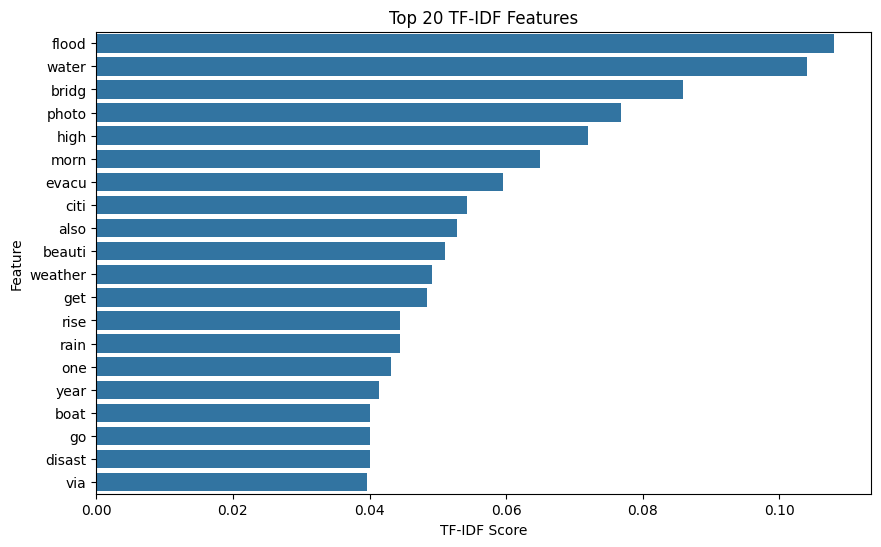

In [20]:
# Tampilkan 20 fitur TF-IDF teratas
top_n = 20
# Kecualikan kolom non-numerik
numeric_tfidf_df = tfidf_normalized_df.select_dtypes(include=[np.number])
tfidf_means = numeric_tfidf_df.mean().sort_values(ascending=False)[:top_n]

plt.figure(figsize=(10, 6))
sns.barplot(x=tfidf_means.values, y=tfidf_means.index)
plt.title('Top 20 TF-IDF Features')
plt.xlabel('TF-IDF Score')
plt.ylabel('Feature')
plt.show()


===== SVM with linear kernel =====
===== K-Fold Cross Validation Results =====

Fold 1:
Training time: 0:00:00.060462
Accuracy: 0.6591

Fold 2:
Training time: 0:00:00.011797
Accuracy: 0.6279

Fold 3:
Training time: 0:00:00.011908
Accuracy: 0.7209

Fold 4:
Training time: 0:00:00.011000
Accuracy: 0.6744

Fold 5:
Training time: 0:00:00.008997
Accuracy: 0.5349

Fold 6:
Training time: 0:00:00.011342
Accuracy: 0.5116

Fold 7:
Training time: 0:00:00.012534
Accuracy: 0.5814

Fold 8:
Training time: 0:00:00.012661
Accuracy: 0.6512

Fold 9:
Training time: 0:00:00.011068
Accuracy: 0.6047

Fold 10:
Training time: 0:00:00.010179
Accuracy: 0.6744

===== Overall Model Performance =====
Mean Accuracy: 0.6240
Standard Deviation: 0.0626
Average Training Time: 0:00:00.016195

===== Combined Performance Metrics =====
Overall Accuracy: 0.6241
Overall Precision: 0.6422
Overall Recall: 0.6241
Overall F1 Score: 0.6254
Overall Error Rate: 0.3759

Combined Confusion Matrix:
[[ 34  21   5]
 [ 39 178  27]
 [ 18  

<Figure size 800x600 with 0 Axes>

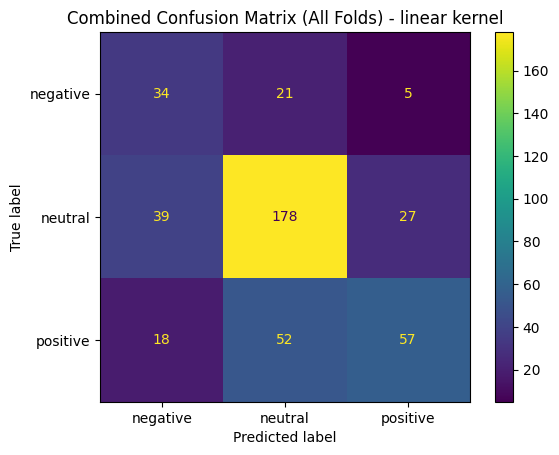


===== SVM with poly kernel =====
===== K-Fold Cross Validation Results =====

Fold 1:
Training time: 0:00:00.016989
Accuracy: 0.5682

Fold 2:
Training time: 0:00:00.014682
Accuracy: 0.5349

Fold 3:
Training time: 0:00:00.014813
Accuracy: 0.6047

Fold 4:
Training time: 0:00:00.013813
Accuracy: 0.5116

Fold 5:
Training time: 0:00:00.013212
Accuracy: 0.6279

Fold 6:
Training time: 0:00:00.011608
Accuracy: 0.6279

Fold 7:
Training time: 0:00:00.011941
Accuracy: 0.6512

Fold 8:
Training time: 0:00:00.015591
Accuracy: 0.7442

Fold 9:
Training time: 0:00:00.014539
Accuracy: 0.6512

Fold 10:
Training time: 0:00:00.021000
Accuracy: 0.5581

===== Overall Model Performance =====
Mean Accuracy: 0.6080
Standard Deviation: 0.0646
Average Training Time: 0:00:00.014819

===== Combined Performance Metrics =====
Overall Accuracy: 0.6079
Overall Precision: 0.5860
Overall Recall: 0.6079
Overall F1 Score: 0.5546
Overall Error Rate: 0.3921

Combined Confusion Matrix:
[[  5  52   3]
 [ 10 217  17]
 [  1  86

<Figure size 800x600 with 0 Axes>

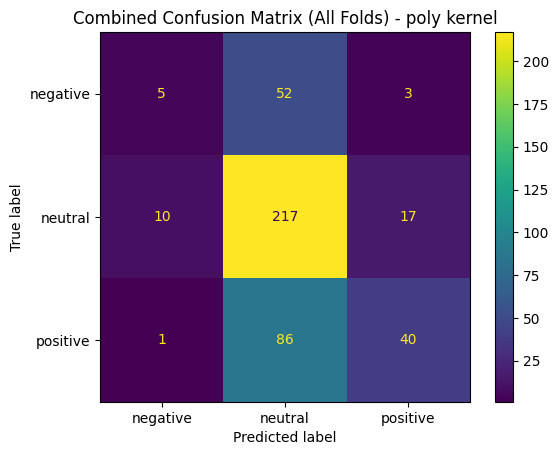


===== SVM with rbf kernel =====
===== K-Fold Cross Validation Results =====

Fold 1:
Training time: 0:00:00.012368
Accuracy: 0.5227

Fold 2:
Training time: 0:00:00.044011
Accuracy: 0.6744

Fold 3:
Training time: 0:00:00.026002
Accuracy: 0.6279

Fold 4:
Training time: 0:00:00.021000
Accuracy: 0.6047

Fold 5:
Training time: 0:00:00.026010
Accuracy: 0.5814

Fold 6:
Training time: 0:00:00.023525
Accuracy: 0.6512

Fold 7:
Training time: 0:00:00.021265
Accuracy: 0.5581

Fold 8:
Training time: 0:00:00.021878
Accuracy: 0.6744

Fold 9:
Training time: 0:00:00.031937
Accuracy: 0.6977

Fold 10:
Training time: 0:00:00.013489
Accuracy: 0.7674

===== Overall Model Performance =====
Mean Accuracy: 0.6360
Standard Deviation: 0.0687
Average Training Time: 0:00:00.024149

===== Combined Performance Metrics =====
Overall Accuracy: 0.6357
Overall Precision: 0.6320
Overall Recall: 0.6357
Overall F1 Score: 0.6336
Overall Error Rate: 0.3643

Combined Confusion Matrix:
[[ 26  25   9]
 [ 21 178  45]
 [  8  49 

<Figure size 800x600 with 0 Axes>

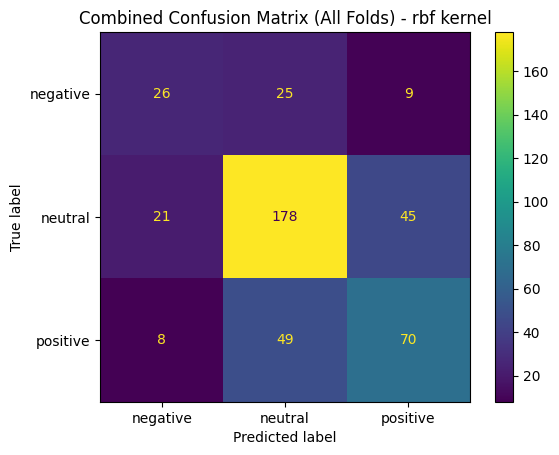


===== SVM with sigmoid kernel =====
===== K-Fold Cross Validation Results =====

Fold 1:
Training time: 0:00:00.019248
Accuracy: 0.5227

Fold 2:
Training time: 0:00:00.015489
Accuracy: 0.5814

Fold 3:
Training time: 0:00:00.011389
Accuracy: 0.5814

Fold 4:
Training time: 0:00:00.012935
Accuracy: 0.5581

Fold 5:
Training time: 0:00:00.009885
Accuracy: 0.6279

Fold 6:
Training time: 0:00:00.009600
Accuracy: 0.7209

Fold 7:
Training time: 0:00:00.011203
Accuracy: 0.6279

Fold 8:
Training time: 0:00:00.011370
Accuracy: 0.7209

Fold 9:
Training time: 0:00:00.012570
Accuracy: 0.6512

Fold 10:
Training time: 0:00:00.010652
Accuracy: 0.7907

===== Overall Model Performance =====
Mean Accuracy: 0.6383
Standard Deviation: 0.0797
Average Training Time: 0:00:00.012434

===== Combined Performance Metrics =====
Overall Accuracy: 0.6381
Overall Precision: 0.6747
Overall Recall: 0.6381
Overall F1 Score: 0.6447
Overall Error Rate: 0.3619

Combined Confusion Matrix:
[[ 38  17   5]
 [ 46 177  21]
 [ 22 

<Figure size 800x600 with 0 Axes>

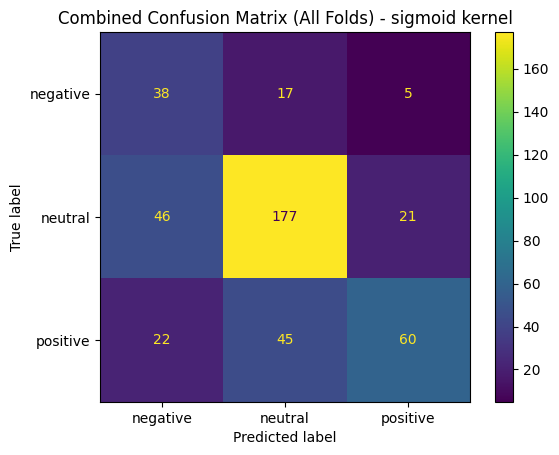

In [25]:
def svm_analysis(X_np, y_np):
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    results = {}

    for kernel in kernels:
        print(f"\n===== SVM with {kernel} kernel =====")
        print("===== K-Fold Cross Validation Results =====")
        kfold = KFold(n_splits=10, shuffle=True)
        classes = np.unique(y_np)
        
        # Inisialisasi daftar untuk menyimpan hasil dari semua lipatan
        all_predictions = []
        all_true_values = []
        fold_accuracies = []
        training_times = []
        
        for i, (train_idx, test_idx) in enumerate(kfold.split(X_np)):
            X_train_fold, X_test_fold = X_np[train_idx], X_np[test_idx]
            y_train_fold, y_test_fold = y_np[train_idx], y_np[test_idx]
            
            # Latih model
            model = SVC(kernel=kernel, class_weight='balanced')
            start_time = time.time()
            model.fit(X_train_fold, y_train_fold)
            end_time = time.time()
            training_time = end_time - start_time
            training_times.append(training_time)
            
            # Buat prediksi
            y_pred = model.predict(X_test_fold)
            acc = accuracy_score(y_test_fold, y_pred)
            fold_accuracies.append(acc)
            
            # Simpan prediksi dan nilai sebenarnya untuk analisis gabungan
            all_predictions.extend(y_pred)
            all_true_values.extend(y_test_fold)
            
            print(f"\nFold {i+1}:")
            print(f"Training time: {str(datetime.timedelta(seconds=training_time))}")
            print(f"Accuracy: {acc:.4f}")
        
        # Hitung statistik
        mean_accuracy = np.mean(fold_accuracies)
        std_accuracy = np.std(fold_accuracies)
        mean_training_time = np.mean(training_times)
        
        print("\n===== Overall Model Performance =====")
        print(f"Mean Accuracy: {mean_accuracy:.4f}")
        print(f"Standard Deviation: {std_accuracy:.4f}")
        print(f"Average Training Time: {str(datetime.timedelta(seconds=mean_training_time))}")
        
        # Hitung metrik gabungan
        cm_combined = confusion_matrix(all_true_values, all_predictions, labels=classes)
        
        # Hitung performa metrik keseluruhan
        accuracy = accuracy_score(all_true_values, all_predictions)
        precision = precision_score(all_true_values, all_predictions, average='weighted', zero_division=0)
        recall = recall_score(all_true_values, all_predictions, average='weighted', zero_division=0)
        f1 = f1_score(all_true_values, all_predictions, average='weighted', zero_division=0)
        
        print("\n===== Combined Performance Metrics =====")
        print(f"Overall Accuracy: {accuracy:.4f}")
        print(f"Overall Precision: {precision:.4f}")
        print(f"Overall Recall: {recall:.4f}")
        print(f"Overall F1 Score: {f1:.4f}")
        print(f"Overall Error Rate: {1 - accuracy:.4f}")
        
        print("\nCombined Confusion Matrix:")
        print(cm_combined)
        print("\nCombined Classification Report:")
        print(classification_report(all_true_values, all_predictions, zero_division=0))

        # Plot confusion matrix gabungan
        plt.figure(figsize=(8,6))
        ConfusionMatrixDisplay(confusion_matrix=cm_combined, display_labels=classes).plot()
        plt.title(f"Combined Confusion Matrix (All Folds) - {kernel} kernel")
        plt.show()
        
        # Simpan hasil untuk setiap kernel
        results[kernel] = {
            'fold_accuracies': fold_accuracies,
            'mean_accuracy': mean_accuracy,
            'std_accuracy': std_accuracy,
            'mean_training_time': mean_training_time,
            'confusion_matrix': cm_combined,
            'classification_report': classification_report(all_true_values, all_predictions, zero_division=0, output_dict=True)
        }
    
    return results

# Konversi matriks sparse ke format dense
X_np = X_tfidf.toarray()
y_np = df['sentiment_label'].values

# Jalankan analisis
results = svm_analysis(X_np, y_np)


===== linear kernel =====
Standard Deviation: 0.0626


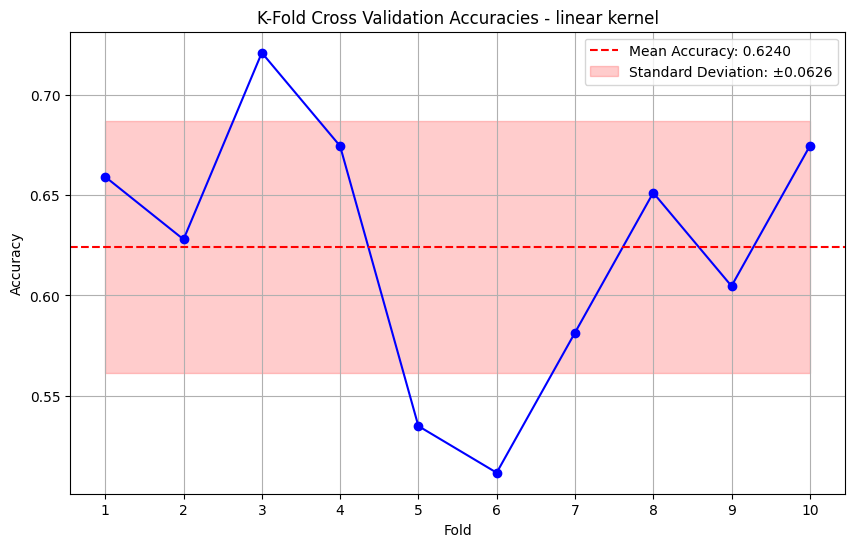


===== poly kernel =====
Standard Deviation: 0.0646


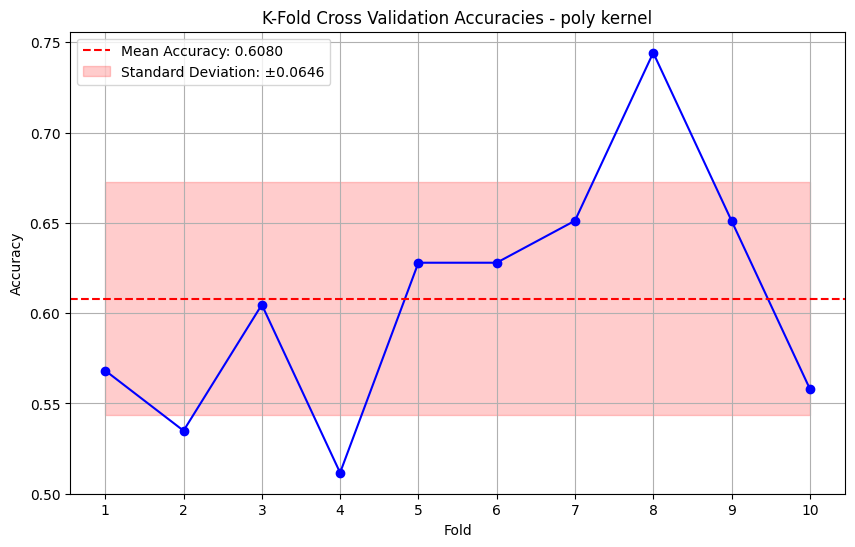


===== rbf kernel =====
Standard Deviation: 0.0687


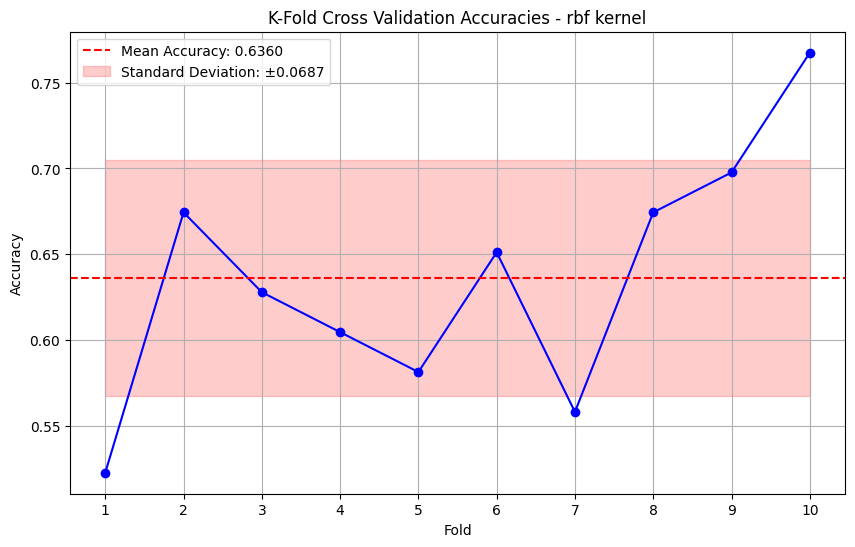


===== sigmoid kernel =====
Standard Deviation: 0.0797


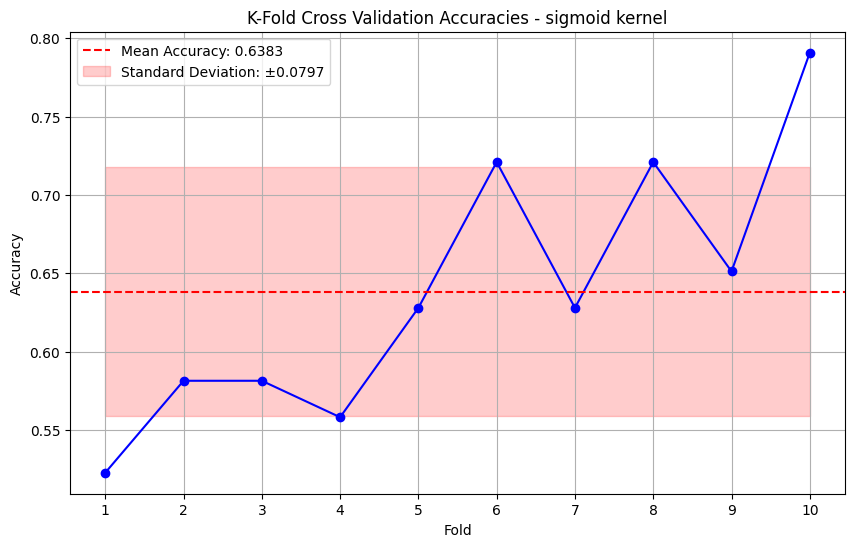

In [26]:
def plot_accuracies(results):
    for kernel, result in results.items():
        fold_accuracies = result['fold_accuracies']
        mean_accuracy = result['mean_accuracy']
        std_accuracy = result['std_accuracy']
        
        # Visualisasikan 10 akurasi
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, 11), fold_accuracies, marker='o', linestyle='-', color='b')
        plt.title(f'K-Fold Cross Validation Accuracies - {kernel} kernel')
        plt.xlabel('Fold')
        plt.ylabel('Accuracy')
        plt.xticks(range(1, 11))
        plt.grid(True)

        # Tampilkan standar deviasi
        print(f"\n===== {kernel} kernel =====")
        print(f"Standard Deviation: {std_accuracy:.4f}")

        # Tambahkan rata-rata akurasi ke plot
        plt.axhline(y=mean_accuracy, color='r', linestyle='--', label=f'Mean Accuracy: {mean_accuracy:.4f}')

        # Tambahkan standar deviasi ke plot
        plt.fill_between(range(1, 11), mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, color='r', alpha=0.2, label=f'Standard Deviation: ±{std_accuracy:.4f}')

        # Tambahkan legenda ke plot
        plt.legend()

        # Tampilkan plot
        plt.show()

plot_accuracies(results)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 431 entries, 0 to 1115
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   english_translation     431 non-null    object 
 1   polarity                431 non-null    float64
 2   sentiment_label         431 non-null    object 
 3   cleaned_text            431 non-null    object 
 4   case_folded_text        431 non-null    object 
 5   tokenized_text          431 non-null    object 
 6   text_without_stopwords  431 non-null    object 
 7   stemmed_text            431 non-null    object 
 8   text_length             431 non-null    int64  
 9   word_count              431 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 37.0+ KB


In [27]:
# Simpan DataFrame ke file Excel
df.to_excel('hasil analisis/hasil_sentiment_analysis_eu_textblob.xlsx', index=False)

# Konfirmasi bahwa file telah disimpan
print("DataFrame has been saved to 'hasil_sentiment_analysis_eu_textblob.xlsx'")

DataFrame has been saved to 'hasil_sentiment_analysis_eu_textblob.xlsx'
